In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '4'
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
df_train = pd.read_csv('../data/FM179-FM181_fingerprints.csv')
df_test = pd.read_csv('../data/FM165/no_sample_id/20241120_1928_MN43023_FAY46018_68f388f5/fastq_pass/fingerprints.csv')
df_test_bp_to_rt = {
    1: "INDURO",
    2: "ProtoScript",
    3: "Marathon",
    4: "GoScript",
    5: "EpiScript",
}
df_test['RT'] = df_test['barcode_num'].map(df_test_bp_to_rt)
df_test = df_test[df_test['isoform'] == 'E']
df_test['experiment'] = 'FM165'
df_test['cap'] = 'Unknown'
df_test

,barcode,isoform,num_reads,num_A,num_C,num_G,num_T,num_DEL,num_INS,barcode_num,...,T%_INSDEL,INS%_INSDEL,DEL%_INSDEL,A%,C%,G%,T%,RT,experiment,cap
5,barcode01,E,16622,5745,1170,2887,847,5145,828,1,...,0.050957,0.049814,0.309530,0.539487,0.109869,0.271105,0.079538,INDURO,FM165,Unknown
25,barcode02,E,1706,707,132,110,107,545,105,2,...,0.062720,0.061547,0.319461,0.669508,0.125000,0.104167,0.101326,ProtoScript,FM165,Unknown
54,barcode03,E,143171,106860,4696,10749,6417,6549,7900,3,...,0.044821,0.055179,0.045743,0.830161,0.036482,0.083506,0.049852,Marathon,FM165,Unknown
81,barcode04,E,40523,13149,2081,2968,2416,16660,3249,4,...,0.059620,0.080177,0.411125,0.637867,0.100951,0.143980,0.117202,GoScript,FM165,Unknown
112,barcode05,E,155480,95708,5202,10119,6696,16758,20997,5,...,0.043067,0.135046,0.107782,0.812979,0.044188,0.085955,0.056878,EpiScript,FM165,Unknown


In [3]:
df_train = df_train[df_train['experiment'] == 'FM180 + FM181']
len(df_train)

20

In [8]:
def mix_fingerprints(
        df: pd.DataFrame, 
        cap_frac_dict: dict,
        include_insdel: bool = False,
    ):

    if include_insdel:
        nuc_cols = ['num_A', 'num_C', 'num_G', 'num_T', 'num_INS', 'num_DEL']
        pct_cols = ['A%_INSDEL', 'C%_INSDEL', 'G%_INSDEL', 'T%_INSDEL', 'INS%_INSDEL', 'DEL%_INSDEL']
    else:
        nuc_cols = ['num_A', 'num_C', 'num_G', 'num_T']
        pct_cols = ['A%', 'C%', 'G%', 'T%']

    if len(df) != 5 * len(cap_frac_dict.keys()):
        raise ValueError("df must have 5 * len(cap_frac_dict.keys()) rows")
    if not set(cap_frac_dict.keys()).issubset(set(df['cap'].unique())):
        raise ValueError("frac_dict keys must be a subset of cap types in df")
    if not np.isclose(sum(cap_frac_dict.values()), 1):
        raise ValueError("fractions must sum to 1")
    
    res_df = []
    for rt in df['RT'].unique():
        rt_df = df[df['RT'] == rt]

        # Convert df to dict
        rt_dict = rt_df.set_index('cap')[nuc_cols].to_dict('index')
        
        # Compute weighted averages
        weighted_counts = {nuc: sum(rt_dict[cap][nuc] * cap_frac_dict[cap] 
                                  for cap in cap_frac_dict)
                         for nuc in nuc_cols}
        weighted_counts['RT'] = rt
        res_df.append(weighted_counts)

    df_result = pd.DataFrame(res_df)

    # Normalize counts to percentages
    total = df_result[nuc_cols].sum(axis=1)
    df_result[pct_cols] = df_result[nuc_cols].div(total, axis=0)
    df_result = df_result.drop(columns=nuc_cols)

    # Save cap_frac_dict info to the result
    df_result['cap'] = ' + '.join(f'{cap} ({frac:.1%})' for cap, frac in cap_frac_dict.items())
    df_result['experiment'] = ' + '.join(df['experiment'].unique())
    return df_result

# df_train_mix = mix_fingerprints(df_train, {'NAD-U1': 0.5, 'Ap₄A-U1': 0.25, 'm⁷Gp₃A-U1': 0.125, 'TMG-U1': 0.125}, include_insdel=True)
df_train_mix = mix_fingerprints(df_train, {'NAD-U1': 1, 'Ap₄A-U1': 0., 'm⁷Gp₃A-U1': 0., 'TMG-U1': 0.}, include_insdel=True)
df_train_mix
    

,RT,A%_INSDEL,C%_INSDEL,G%_INSDEL,T%_INSDEL,INS%_INSDEL,DEL%_INSDEL,cap,experiment
0,INDURO,0.720829,0.028410,0.047685,0.058342,0.097878,0.046857,NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (...,FM180 + FM181
1,ProtoScript,0.657159,0.041568,0.054001,0.062108,0.072591,0.112574,NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (...,FM180 + FM181
2,Marathon,0.727099,0.025955,0.045368,0.055984,0.079556,0.066037,NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (...,FM180 + FM181
3,GoScript,0.290837,0.061089,0.044204,0.144375,0.137166,0.322330,NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (...,FM180 + FM181
4,EpiScript,0.678365,0.031689,0.079770,0.028739,0.143072,0.038364,NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (...,FM180 + FM181


In [9]:
from itertools import product
from tqdm import tqdm

def generate_combinations(step_size=0.02):
    values = np.arange(0, 1 + step_size, step_size)
    for nad, ap4a, m7g in product(values, values, values):
        tmg = 1 - nad - ap4a - m7g
        if 0 <= tmg <= 1:  # Only keep combinations where TMG fraction is valid
            yield float(nad), float(ap4a), float(m7g), float(tmg)

# Calculate total number of combinations
total = sum(1 for _ in generate_combinations())

df_train_mixes = pd.concat([
    mix_fingerprints(df_train, {
        'NAD-U1': nad,
        'Ap₄A-U1': ap4a,
        'm⁷Gp₃A-U1': m7g,
        'TMG-U1': tmg
    },
    include_insdel=True
    )
    for nad, ap4a, m7g, tmg in tqdm(generate_combinations(), total=total, desc='Generating combinations')
])

Generating combinations: 100%|██████████| 22907/22907 [04:16<00:00, 89.24it/s]


In [10]:
print(len(df_train_mixes))

114535


In [11]:
from rnacappredictor.predict_cap import predict_cap
df_pred = predict_cap(df_train_mixes, df_test, include_insdel=True)

Experiment: FM165
5 RTs considered for prediction(['INDURO', 'ProtoScript', 'Marathon', 'GoScript', 'EpiScript']) with mean number of reads 55753.2
Top-1 prediction: NAD-U1 (100.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (0.0%) (FM180 + FM181) with similarity 0.916
Top-2 prediction: NAD-U1 (98.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (2.0%) (FM180 + FM181) with similarity 0.916
Top-3 prediction: NAD-U1 (96.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (4.0%) (FM180 + FM181) with similarity 0.916
Top-4 prediction: NAD-U1 (94.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (6.0%) (FM180 + FM181) with similarity 0.916
Top-5 prediction: NAD-U1 (92.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (8.0%) (FM180 + FM181) with similarity 0.916
Top-6 prediction: NAD-U1 (90.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (10.0%) (FM180 + FM181) with similarity 0.916
Top-7 prediction: NAD-U1 (88.0%) + Ap₄A-U1 (0.0%) + m⁷Gp₃A-U1 (0.0%) + TMG-U1 (12.0%) (FM180 + FM181) with simil

In [19]:
# Get number of predictions by counting prediction_X columns
num_preds = len([col for col in df_pred.columns if col.startswith('prediction_')])

import re

# Function to extract percentages from prediction string
def extract_cap_percentages(pred_str):
    nad = float(re.search(r'NAD-U1 \(([\d.]+)%\)', pred_str).group(1))
    ap4a = float(re.search(r'Ap₄A-U1 \(([\d.]+)%\)', pred_str).group(1))
    m7g = float(re.search(r'm⁷Gp₃A-U1 \(([\d.]+)%\)', pred_str).group(1))
    tmg = float(re.search(r'TMG-U1 \(([\d.]+)%\)', pred_str).group(1))
    return nad, ap4a, m7g, tmg

# Create new dataframe with predictions and similarities as separate rows
predictions = [df_pred[f'prediction_{i}'].iloc[0] for i in range(1, num_preds + 1)]
similarities = [df_pred[f'similarity_{i}'].iloc[0] for i in range(1, num_preds + 1)]

# Extract percentages for each cap
cap_percentages = [extract_cap_percentages(pred) for pred in predictions]

df_top = pd.DataFrame({
    'prediction': predictions,
    'NAD-U1 (%)': [p[0] for p in cap_percentages],
    'Ap₄A-U1 (%)': [p[1] for p in cap_percentages], 
    'm⁷Gp₃A-U1 (%)': [p[2] for p in cap_percentages],
    'TMG-U1 (%)': [p[3] for p in cap_percentages],
    'similarity': similarities
}).sort_values('similarity', ascending=False)

df_top = df_top.drop(columns=['prediction'])

display(df_top.style.hide(axis='index'))

NAD-U1 (%),Ap₄A-U1 (%),m⁷Gp₃A-U1 (%),TMG-U1 (%),similarity
100.000000,0.000000,0.000000,0.000000,0.916070
98.000000,0.000000,0.000000,2.000000,0.916049
96.000000,0.000000,0.000000,4.000000,0.916027
94.000000,0.000000,0.000000,6.000000,0.916004
92.000000,0.000000,0.000000,8.000000,0.915980
90.000000,0.000000,0.000000,10.000000,0.915955
88.000000,0.000000,0.000000,12.000000,0.915928
98.000000,0.000000,2.000000,0.000000,0.915919
86.000000,0.000000,0.000000,14.000000,0.915899
96.000000,0.000000,2.000000,2.000000,0.915891


In [18]:
!pip install Jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [Jinja2]2m1/2 [Jinja2]


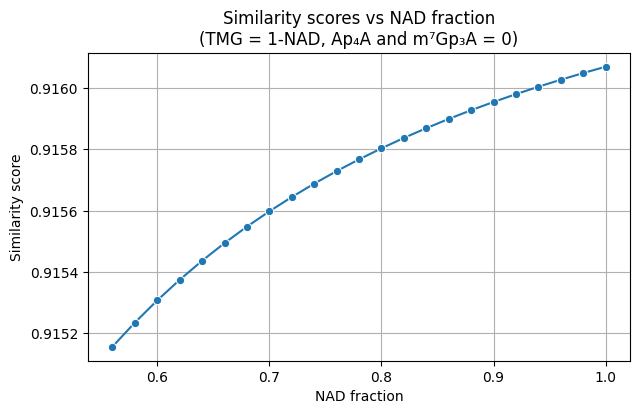

In [9]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract percentages from prediction string
def extract_percentages(pred_str):
    matches = re.findall(r'NAD-U1 \(([\d.]+)%\).*?TMG-U1 \(([\d.]+)%\)', pred_str)
    if matches:
        nad_pct, tmg_pct = matches[0]
        return float(nad_pct)/100, float(tmg_pct)/100
    return None

# Filter predictions where Ap4A and m7G are 0%
filtered_preds = []
for _, row in df_pred.iterrows():
    # Check all predictions for this row
    for i in range(1, len([col for col in df_pred.columns if col.startswith('prediction_')]) + 1):
        pred = row[f'prediction_{i}']
        if 'Ap₄A-U1 (0.0%)' in pred and 'm⁷Gp₃A-U1 (0.0%)' in pred:
            percentages = extract_percentages(pred)
            if percentages:
                nad_frac, tmg_frac = percentages
                filtered_preds.append({
                    'NAD': nad_frac,
                    'TMG': tmg_frac,
                    'similarity': row[f'similarity_{i}'],
                    'rank': i
                })

# Convert to DataFrame
plot_df = pd.DataFrame(filtered_preds)

# Sort by NAD fraction for line plot
plot_df = plot_df.sort_values('NAD')

# Find NAD fraction with maximum similarity
max_sim_idx = plot_df['similarity'].idxmax()
max_nad = plot_df.loc[max_sim_idx, 'NAD']
max_sim = plot_df.loc[max_sim_idx, 'similarity']

# Create line plot using seaborn
plt.figure(figsize=(7, 4))
sns.lineplot(data=plot_df, x='NAD', y='similarity', marker='o')
# plt.axvline(x=max_nad, color='r', linestyle='--', alpha=0.5)
# plt.text(max_nad - 0.03, max_sim + 0.001, f'NAD = {max_nad:.2f}\nTMG = {1 - max_nad:.2f}', rotation=90)
plt.title('Similarity scores vs NAD fraction\n(TMG = 1-NAD, Ap₄A and m⁷Gp₃A = 0)')
plt.xlabel('NAD fraction')
plt.ylabel('Similarity score')
plt.grid(True)
plt.show()

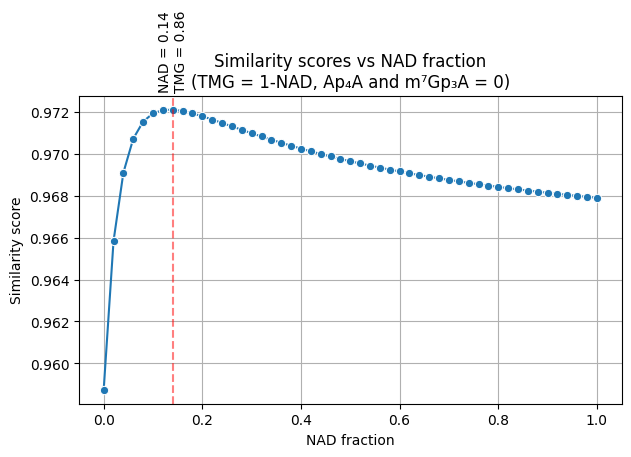

In [59]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract percentages from prediction string
def extract_percentages(pred_str):
    matches = re.findall(r'NAD-U1 \(([\d.]+)%\).*?TMG-U1 \(([\d.]+)%\)', pred_str)
    if matches:
        nad_pct, tmg_pct = matches[0]
        return float(nad_pct)/100, float(tmg_pct)/100
    return None

# Filter predictions where Ap4A and m7G are 0%
filtered_preds = []
for _, row in df_pred.iterrows():
    # Check all predictions for this row
    for i in range(1, len([col for col in df_pred.columns if col.startswith('prediction_')]) + 1):
        pred = row[f'prediction_{i}']
        if 'Ap₄A-U1 (0.0%)' in pred and 'm⁷Gp₃A-U1 (0.0%)' in pred:
            percentages = extract_percentages(pred)
            if percentages:
                nad_frac, tmg_frac = percentages
                filtered_preds.append({
                    'NAD': nad_frac,
                    'TMG': tmg_frac,
                    'similarity': row[f'similarity_{i}'],
                    'rank': i
                })

# Convert to DataFrame
plot_df = pd.DataFrame(filtered_preds)

# Sort by NAD fraction for line plot
plot_df = plot_df.sort_values('NAD')

# Find NAD fraction with maximum similarity
max_sim_idx = plot_df['similarity'].idxmax()
max_nad = plot_df.loc[max_sim_idx, 'NAD']
max_sim = plot_df.loc[max_sim_idx, 'similarity']

# Create line plot using seaborn
plt.figure(figsize=(7, 4))
sns.lineplot(data=plot_df, x='NAD', y='similarity', marker='o')
plt.axvline(x=max_nad, color='r', linestyle='--', alpha=0.5)
plt.text(max_nad - 0.03, max_sim + 0.001, f'NAD = {max_nad:.2f}\nTMG = {1 - max_nad:.2f}', rotation=90)
plt.title('Similarity scores vs NAD fraction\n(TMG = 1-NAD, Ap₄A and m⁷Gp₃A = 0)')
plt.xlabel('NAD fraction')
plt.ylabel('Similarity score')
plt.grid(True)
plt.show()